In [4]:
import os
# 切換到專案資料夾
os.chdir(r"C:\Users\user\Desktop\Python作品集\ETF_Portfolio_Optimization")

# 確認當前工作目錄
print(os.getcwd())


# 讀取原始價格資料
df = pd.read_csv("data/etf_price_raw.csv", dtype={"stock_id": str})


# 檢查前幾列
df.head()

# 將資料轉成寬表格式（每個 ETF 為一欄）
df_wide = df.pivot(index="date", columns="stock_id", values="close")

# 按日期排序
df_wide = df_wide.sort_index()

# 檢查結果
df_wide.head()


C:\Users\user\Desktop\Python作品集\ETF_Portfolio_Optimization


stock_id,0050,006208,00878
date,,,
2020-01-02,97.65,54.10,NaN
2020-01-03,97.65,54.05,NaN
2020-01-06,96.40,53.65,NaN
2020-01-07,96.10,53.25,NaN
2020-01-08,95.65,53.00,NaN


In [6]:
# 缺失值處理（用前一天數值填補）
df_wide = df_wide.ffill()

# 計算每日報酬率
df_returns = df_wide.pct_change().dropna()

# 檢查結果
print("每日報酬率：")
print(df_returns.head())

# 儲存清理後資料
df_wide.to_csv("data/etf_price_clean.csv", encoding="utf-8-sig")
df_returns.to_csv("data/etf_returns.csv", encoding="utf-8-sig")
print("已儲存 etf_price_clean.csv 與 etf_returns.csv")


每日報酬率：
stock_id        0050    006208     00878
date                                    
2020-07-21  0.017002  0.014414  0.027415
2020-07-22  0.002533  0.002664 -0.027319
2020-07-23 -0.001011 -0.000886 -0.011104
2020-07-24 -0.003541 -0.003546 -0.005945
2020-07-27  0.048731  0.048932 -0.004651
已儲存 etf_price_clean.csv 與 etf_returns.csv


In [7]:
import numpy as np

# 年交易日數
trading_days = 252

# 計算年化報酬率
annual_returns = df_returns.mean() * trading_days

# 計算年化波動率
annual_volatility = df_returns.std() * np.sqrt(trading_days)

# 計算夏普比率（假設無風險利率為 0）
sharpe_ratio = annual_returns / annual_volatility

# 整理成 DataFrame
performance = pd.DataFrame({
    "Annual Return": annual_returns,
    "Annual Volatility": annual_volatility,
    "Sharpe Ratio": sharpe_ratio
})

# 輸出結果
print(performance)

# 儲存績效資料
performance.to_csv("data/etf_performance.csv", encoding="utf-8-sig")
print("已儲存 etf_performance.csv")


          Annual Return  Annual Volatility  Sharpe Ratio
stock_id                                                
0050           0.021763           0.400362      0.054357
006208         0.179631           0.204430      0.878694
00878          0.078198           0.148238      0.527521
已儲存 etf_performance.csv


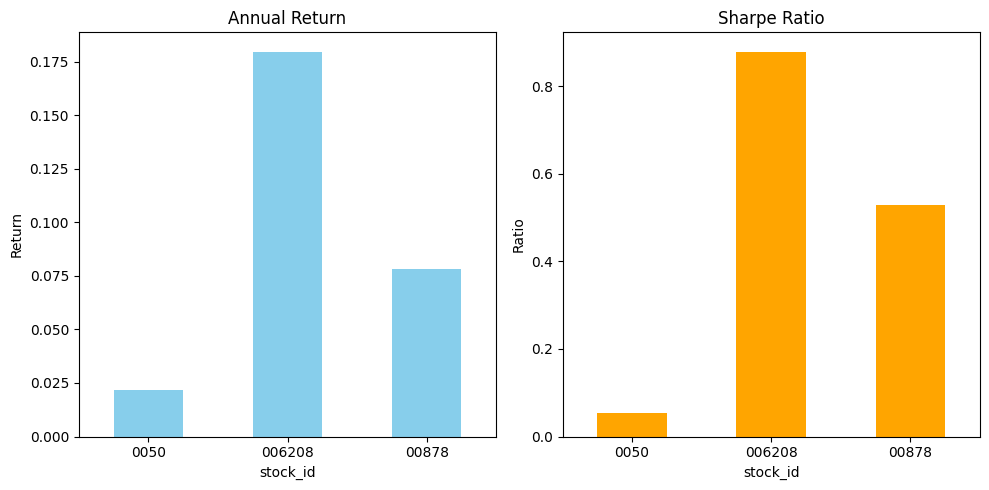

In [8]:
import matplotlib.pyplot as plt

# 設定圖表大小
plt.figure(figsize=(10,5))

# 年化報酬率圖
plt.subplot(1, 2, 1)
performance["Annual Return"].plot(kind="bar", color="skyblue")
plt.title("Annual Return")
plt.ylabel("Return")
plt.xticks(rotation=0)

# 夏普比率圖
plt.subplot(1, 2, 2)
performance["Sharpe Ratio"].plot(kind="bar", color="orange")
plt.title("Sharpe Ratio")
plt.ylabel("Ratio")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


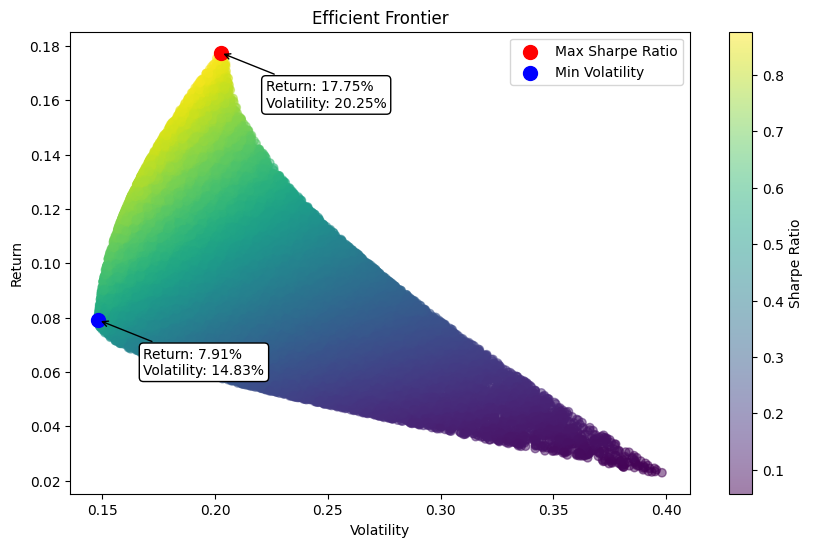

最大夏普比率組合：
Return          0.177528
Volatility      0.202547
Sharpe Ratio    0.876479
0050            0.000252
006208          0.979407
00878           0.020341
Name: 39869, dtype: float64

最佳組合權重：
0050: 0.03%
006208: 97.94%
00878: 2.03%

最小波動率組合：
Return          0.079112
Volatility      0.148318
Sharpe Ratio    0.533393
0050            0.001771
006208          0.009988
00878           0.988241
Name: 46694, dtype: float64

最小波動率組合權重：
0050: 0.18%
006208: 1.00%
00878: 98.82%


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 參數設定 =====
num_portfolios = 50000
risk_free_rate = 0.0  # 無風險利率

# ===== 計算平均報酬率 & 共變異矩陣 =====
returns_mean = df_returns.mean() * trading_days
cov_matrix = df_returns.cov() * trading_days

# 儲存模擬結果
results = np.zeros((3 + len(df_wide.columns), num_portfolios))

# ===== Monte Carlo 模擬 =====
for i in range(num_portfolios):
    # 隨機權重
    weights = np.random.random(len(df_wide.columns))
    weights /= np.sum(weights)
    
    # 年化報酬率 & 波動率
    portfolio_return = np.dot(weights, returns_mean)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # 夏普比率
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    # 儲存結果
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe
    for j in range(len(weights)):
        results[3 + j, i] = weights[j]

# ===== 轉 DataFrame =====
columns = ['Return', 'Volatility', 'Sharpe Ratio'] + list(df_wide.columns)
portfolios = pd.DataFrame(results.T, columns=columns)

# ===== 找出最大夏普比率 & 最小波動率組合 =====
max_sharpe_port = portfolios.loc[portfolios['Sharpe Ratio'].idxmax()]
min_vol_port = portfolios.loc[portfolios['Volatility'].idxmin()]

# ===== 畫有效前緣 =====
plt.figure(figsize=(10,6))
plt.scatter(portfolios['Volatility'], portfolios['Return'], 
            c=portfolios['Sharpe Ratio'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')

# 標記最大夏普比率組合（紅點）
plt.scatter(max_sharpe_port['Volatility'], max_sharpe_port['Return'], 
            c='red', s=100, label='Max Sharpe Ratio')
plt.annotate(
    f"Return: {max_sharpe_port['Return']:.2%}\nVolatility: {max_sharpe_port['Volatility']:.2%}",
    xy=(max_sharpe_port['Volatility'], max_sharpe_port['Return']),
    xytext=(max_sharpe_port['Volatility']+0.02, max_sharpe_port['Return']-0.02),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

# 標記最小波動率組合（藍點）
plt.scatter(min_vol_port['Volatility'], min_vol_port['Return'], 
            c='blue', s=100, label='Min Volatility')
plt.annotate(
    f"Return: {min_vol_port['Return']:.2%}\nVolatility: {min_vol_port['Volatility']:.2%}",
    xy=(min_vol_port['Volatility'], min_vol_port['Return']),
    xytext=(min_vol_port['Volatility']+0.02, min_vol_port['Return']-0.02),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()

# ===== 輸出組合權重 =====
print("最大夏普比率組合：")
print(max_sharpe_port)
print("\n最佳組合權重：")
for etf, weight in max_sharpe_port[3:].items():
    print(f"{etf}: {weight:.2%}")

print("\n最小波動率組合：")
print(min_vol_port)
print("\n最小波動率組合權重：")
for etf, weight in min_vol_port[3:].items():
    print(f"{etf}: {weight:.2%}")


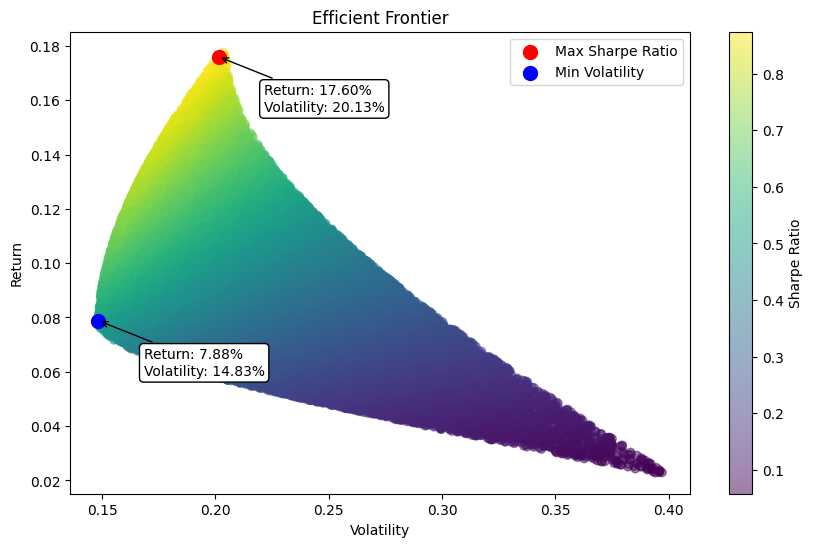

最大夏普比率組合：
Return          0.176015
Volatility      0.201332
Sharpe Ratio    0.874254
0050            0.001331
006208          0.965092
00878           0.033577
Name: 45953, dtype: float64

最佳組合權重：
0050: 0.13%
006208: 96.51%
00878: 3.36%

最小波動率組合：
Return          0.078838
Volatility      0.148299
Sharpe Ratio    0.531617
0050            0.001719
006208          0.007264
00878           0.991017
Name: 40463, dtype: float64

最小波動率組合權重：
0050: 0.17%
006208: 0.73%
00878: 99.10%


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 如果資料夾不存在就建立
os.makedirs("visuals", exist_ok=True)

# ===== 參數設定 =====
num_portfolios = 50000
risk_free_rate = 0.0  # 無風險利率

# ===== 計算平均報酬率 & 共變異矩陣 =====
returns_mean = df_returns.mean() * trading_days
cov_matrix = df_returns.cov() * trading_days

# 儲存模擬結果
results = np.zeros((3 + len(df_wide.columns), num_portfolios))

# ===== Monte Carlo 模擬 =====
for i in range(num_portfolios):
    # 隨機權重
    weights = np.random.random(len(df_wide.columns))
    weights /= np.sum(weights)
    
    # 年化報酬率 & 波動率
    portfolio_return = np.dot(weights, returns_mean)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # 夏普比率
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    # 儲存結果
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe
    for j in range(len(weights)):
        results[3 + j, i] = weights[j]

# ===== 轉 DataFrame =====
columns = ['Return', 'Volatility', 'Sharpe Ratio'] + list(df_wide.columns)
portfolios = pd.DataFrame(results.T, columns=columns)

# ===== 找出最大夏普比率 & 最小波動率組合 =====
max_sharpe_port = portfolios.loc[portfolios['Sharpe Ratio'].idxmax()]
min_vol_port = portfolios.loc[portfolios['Volatility'].idxmin()]

# ===== 畫有效前緣 =====
plt.figure(figsize=(10,6))
plt.scatter(portfolios['Volatility'], portfolios['Return'], 
            c=portfolios['Sharpe Ratio'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')

# 標記最大夏普比率組合（紅點）
plt.scatter(max_sharpe_port['Volatility'], max_sharpe_port['Return'], 
            c='red', s=100, label='Max Sharpe Ratio')
plt.annotate(
    f"Return: {max_sharpe_port['Return']:.2%}\nVolatility: {max_sharpe_port['Volatility']:.2%}",
    xy=(max_sharpe_port['Volatility'], max_sharpe_port['Return']),
    xytext=(max_sharpe_port['Volatility']+0.02, max_sharpe_port['Return']-0.02),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

# 標記最小波動率組合（藍點）
plt.scatter(min_vol_port['Volatility'], min_vol_port['Return'], 
            c='blue', s=100, label='Min Volatility')
plt.annotate(
    f"Return: {min_vol_port['Return']:.2%}\nVolatility: {min_vol_port['Volatility']:.2%}",
    xy=(min_vol_port['Volatility'], min_vol_port['Return']),
    xytext=(min_vol_port['Volatility']+0.02, min_vol_port['Return']-0.02),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()

# ✅ 自動儲存圖片
plt.savefig("visuals/efficient_frontier.png", dpi=300)
plt.show()

# ===== 輸出組合權重 =====
print("最大夏普比率組合：")
print(max_sharpe_port)
print("\n最佳組合權重：")
for etf, weight in max_sharpe_port[3:].items():
    print(f"{etf}: {weight:.2%}")

print("\n最小波動率組合：")
print(min_vol_port)
print("\n最小波動率組合權重：")
for etf, weight in min_vol_port[3:].items():
    print(f"{etf}: {weight:.2%}")


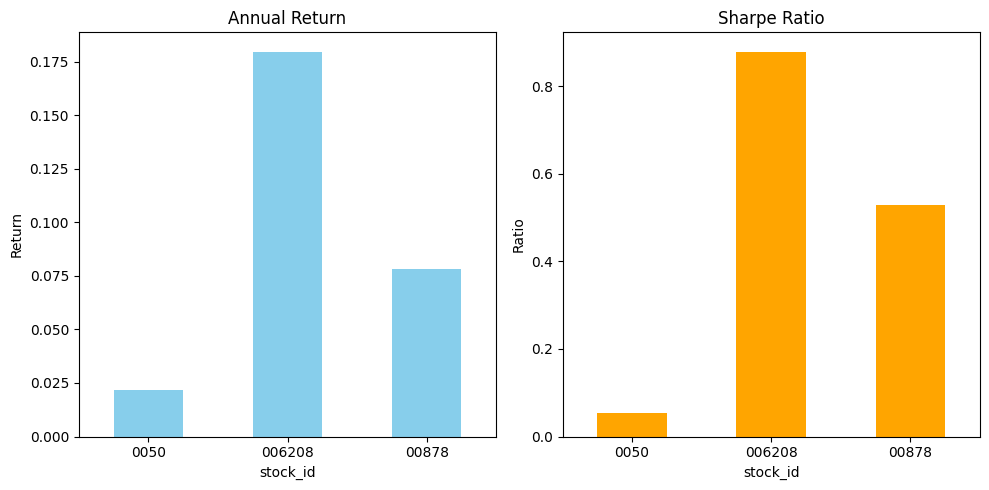

已儲存到 visuals/performance_chart.png


In [14]:
import os
import matplotlib.pyplot as plt

# 如果資料夾不存在就建立
os.makedirs("visuals", exist_ok=True)

plt.figure(figsize=(10,5))

# 年化報酬率圖
plt.subplot(1, 2, 1)
performance["Annual Return"].plot(kind="bar", color="skyblue")
plt.title("Annual Return")
plt.ylabel("Return")
plt.xticks(rotation=0)

# 夏普比率圖
plt.subplot(1, 2, 2)
performance["Sharpe Ratio"].plot(kind="bar", color="orange")
plt.title("Sharpe Ratio")
plt.ylabel("Ratio")
plt.xticks(rotation=0)

plt.tight_layout()

# ✅ 自動儲存圖片
plt.savefig("visuals/performance_chart.png", dpi=300)
plt.show()

print("已儲存到 visuals/performance_chart.png")
